In [13]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from sklearn.metrics.pairwise import cosine_similarity
from skimage.metrics import structural_similarity

In [14]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

c:\Users\Jainish\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [15]:
base_dir = "./images"
original_dir = os.path.join(base_dir, "Original")
models_dirs = {
    "Platform": os.path.join(base_dir, "Platform"),
    "Google Imagen 3": os.path.join(base_dir, "Google Imagen"),
    "OpenAI Dalle 3": os.path.join(base_dir, "Dalle"),
}

In [16]:
original_images = []
original_image_info = {}
for index, image_path in enumerate(os.listdir(original_dir)):
    img = Image.open(f'{original_dir}/{image_path}')
    original_images.append(img)
    original_image_info[index] = {"name": image_path.replace(".png", "").replace(".jpg", ""), "image": img}

In [17]:
all_images = [original_images]  
model_image_info = {}
for model_name, model_dir in models_dirs.items():
    model_images = []
    for image_path in os.listdir(model_dir):
        img = Image.open(f'{model_dir}/{image_path}')
        model_images.append(img)
    model_image_info[model_name] = model_images
    all_images.append(model_images)

flattened_images = original_images[:]
for model_images in model_image_info.values():
    flattened_images.extend(model_images)

In [18]:
inputs = processor(images=flattened_images, return_tensors="pt", padding=True)

with torch.no_grad():
    image_features = model.get_image_features(**inputs)

In [19]:
def compare_images(image_features, img1_idx, img2_idx, original_image, compared_image):
    original_image_resized = original_image.resize(compared_image.size)
    
    original_image_array = np.array(original_image_resized.convert("L"))
    compared_image_array = np.array(compared_image.convert("L"))
    
    cosine_sim = cosine_similarity(image_features[img1_idx].unsqueeze(0), image_features[img2_idx].unsqueeze(0))[0][0]
    
    ssim = structural_similarity(original_image_array, compared_image_array)
    
    return cosine_sim, ssim


In [20]:
cosine_similarities = []
structural_similarities = []
labels = []


for index, info in original_image_info.items():
    original_image = info['image']  
    
    for model_name, model_images in model_image_info.items():
        if index >= len(model_images):
            print(f"No image at index {index} for model {model_name}")
            continue
        
        compared_image = model_images[index]  
        
        compared_image_idx = len(original_images) + list(model_image_info.keys()).index(model_name) * len(original_images) + index
        
        try:
            cosine_sim, ssim = compare_images(image_features, index, compared_image_idx, original_image, compared_image)
            
            cosine_similarities.append(cosine_sim)
            structural_similarities.append(ssim)
            labels.append(f'{model_name} - {info["name"]}')
        
        except Exception as e:
            print(f"Error comparing images at index {index} for model {model_name}: {e}")



In [21]:
categories = ['Platform', 'Google Imagen 3', 'OpenAI Dalle 3']
avg_cosine = []
avg_ssim = []

for category in categories:
    category_cosine = [cos for cos, label in zip(cosine_similarities, labels) if category in label]
    category_ssim = [ssim for ssim, label in zip(structural_similarities, labels) if category in label]
    
    avg_cosine.append(np.mean(category_cosine))
    avg_ssim.append(np.mean(category_ssim))

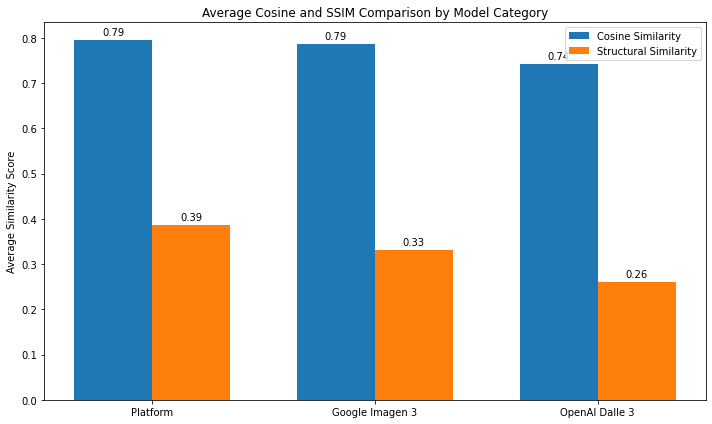

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))

width = 0.35
x = np.arange(len(categories))

rects1 = ax.bar(x - width/2, avg_cosine, width, label='Cosine Similarity', color='#1f77b4')
rects2 = ax.bar(x + width/2, avg_ssim, width, label='Structural Similarity', color='#ff7f0e')

ax.set_ylabel('Average Similarity Score')
ax.set_title('Average Cosine and SSIM Comparison by Model Category')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()